In [186]:
using DIVAnd
using Dates
using NCDatasets
using Test
using PyPlot
using Statistics
using DelimitedFiles
using Glob
const plt = PyPlot
using PyCall
include("./ME4OH.jl")
include("./config.jl")

ccrs = pyimport("cartopy.crs")
myproj = ccrs.PlateCarree(central_longitude=180.0)

[ Info: File already downloaded


PyObject <Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=180.0 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Read all the data together

In [2]:
thetimeperiod = timeperiod1
datadirdisk = "/media/ctroupin/T7 Shield/000060826v009/data/en4.1.1/$(thetimeperiod[1])-$(thetimeperiod[end])"
datafilelist = ME4OH.get_filelist(datadirdisk);

[ Info: Found 432 files


In [153]:
function super_read_profile(datafile::AbstractString)
    NCDataset(datafile, "r") do ds
        lon = ds["ts_lon"][:]
        lat = ds["ts_lat"][:]
        time = ds["en4_ymd"][:,:]
        dates = Dates.DateTime.(time[1,:], time[2,:], time[3,:])
        vertical_levels = ds["ts_z"][:]
        depth_level_thickness = ds["ts_dz"][:]
        bounds = ds["ts_bound"][:,:]
        T = ds["temp"][:,:]
        SSH = ds["eta_t"][:]
        SST = ds["sst"][:]
        S = ds["salt"][:,:]
        dohc = ds["dohc"][:,:]
        adohc = ds["adohc"][:,:]
        dadohc = ds["dadohc"][:,:]

        varlist = keys(ds)
        if "dohc_mask_by_en4_maxdepth" in varlist
            @debug("Reading dohc_mask_by_en4_maxdepth from file")
            dohc_mask = Bool.(ds["dohc_mask_by_en4_maxdepth"][:,:])
        else
            dohc_mask = ones(Bool, size(dohc))
        end

        return lon::Vector{Float32}, lat::Vector{Float32}, dates::Vector{DateTime}, 
        vertical_levels::Vector{Float32}, T::Matrix{Float32}, S::Matrix{Float32}, 
        dohc::Matrix{Float32}, adohc::Matrix{Float32}, dadohc::Matrix{Float32},
        dohc_mask::AbstractArray{Bool}, bounds::Matrix{Float32}, depth_level_thickness::Vector{Float32}
    end
end

super_read_profile (generic function with 1 method)

In [188]:
@time lon, lat, dates, dohc, adohc, dadohc, dohc_mask, ts_bounds, depth_level_thickness = 
ME4OH.read_profile(datafilelist);
lon[lon.< 20.] .+= 360.;
@info("Read $(length(lon)) observations")
@info(size(dohc))

  4.513534 seconds (1.02 M allocations: 12.548 GiB, 6.96% gc time)


[ Info: Read 5710432 observations
[ Info: (3, 5710432)


In [189]:
dohc_vec = Float64.(dohc'[:]);

## Plots to check

In [162]:
# Loop on layer
for iii = 1:1
    # Loop on month
    for mm = 1:2
        goodtime = findall(Dates.month.(dates) .== mm)

        fig = plt.figure(figsize=(12, 8))
        ax = plt.subplot(111, projection=myproj, frameon=false)
        ax.set_global()
        ax.coastlines(lw=.5)
        scat = ax.scatter(lon[goodtime], lat[goodtime], s=1, c=dohc[iii,goodtime], 
            cmap=plt.cm.RdYlBu_r, transform=ccrs.PlateCarree())
        cb = plt.colorbar(scat, shrink=.6)
        cb.set_label("TJ/m²", rotation=0, ha="left")
        ax.set_title("Ocean heat content density in layer $(depthlayers[iii][1]) - $(depthlayers[iii][end]) m\n$(Dates.monthname(mm)) $(thetimeperiod[1]) - $(thetimeperiod[end])")
        plt.savefig(joinpath(figdir, "dohc_layer$(iii)_month$(lpad(mm, 2, '0'))_period_$(thetimeperiod[1])-$(thetimeperiod[end])_Test"))
        plt.close()    
    end
end 
@info("Check for figures in $(figdir)")

[ Info: Check for figures in ../figures/


In [190]:
depthgrid = [depthlayer1[end], depthlayer2[end], depthlayer3[end]]
xi, yi, mask_dohc = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);

In [191]:
lon3 = Float64.(repeat(lon, length(depthgrid)));
lat3 = Float64.(repeat(lat, length(depthgrid)));
dates3 = repeat(dates, length(depthgrid));
depth3 = repeat(depthgrid, outer=[1,length(lon)]);
depth3 = depth3'[:];

In [192]:
goodvalues = .!(isnan.(dohc_vec))

dohc3 = dohc_vec[goodvalues];
lon3 = lon3[goodvalues]
lat3 = lat3[goodvalues]
dates3 = dates3[goodvalues]
depth3 = depth3[goodvalues];

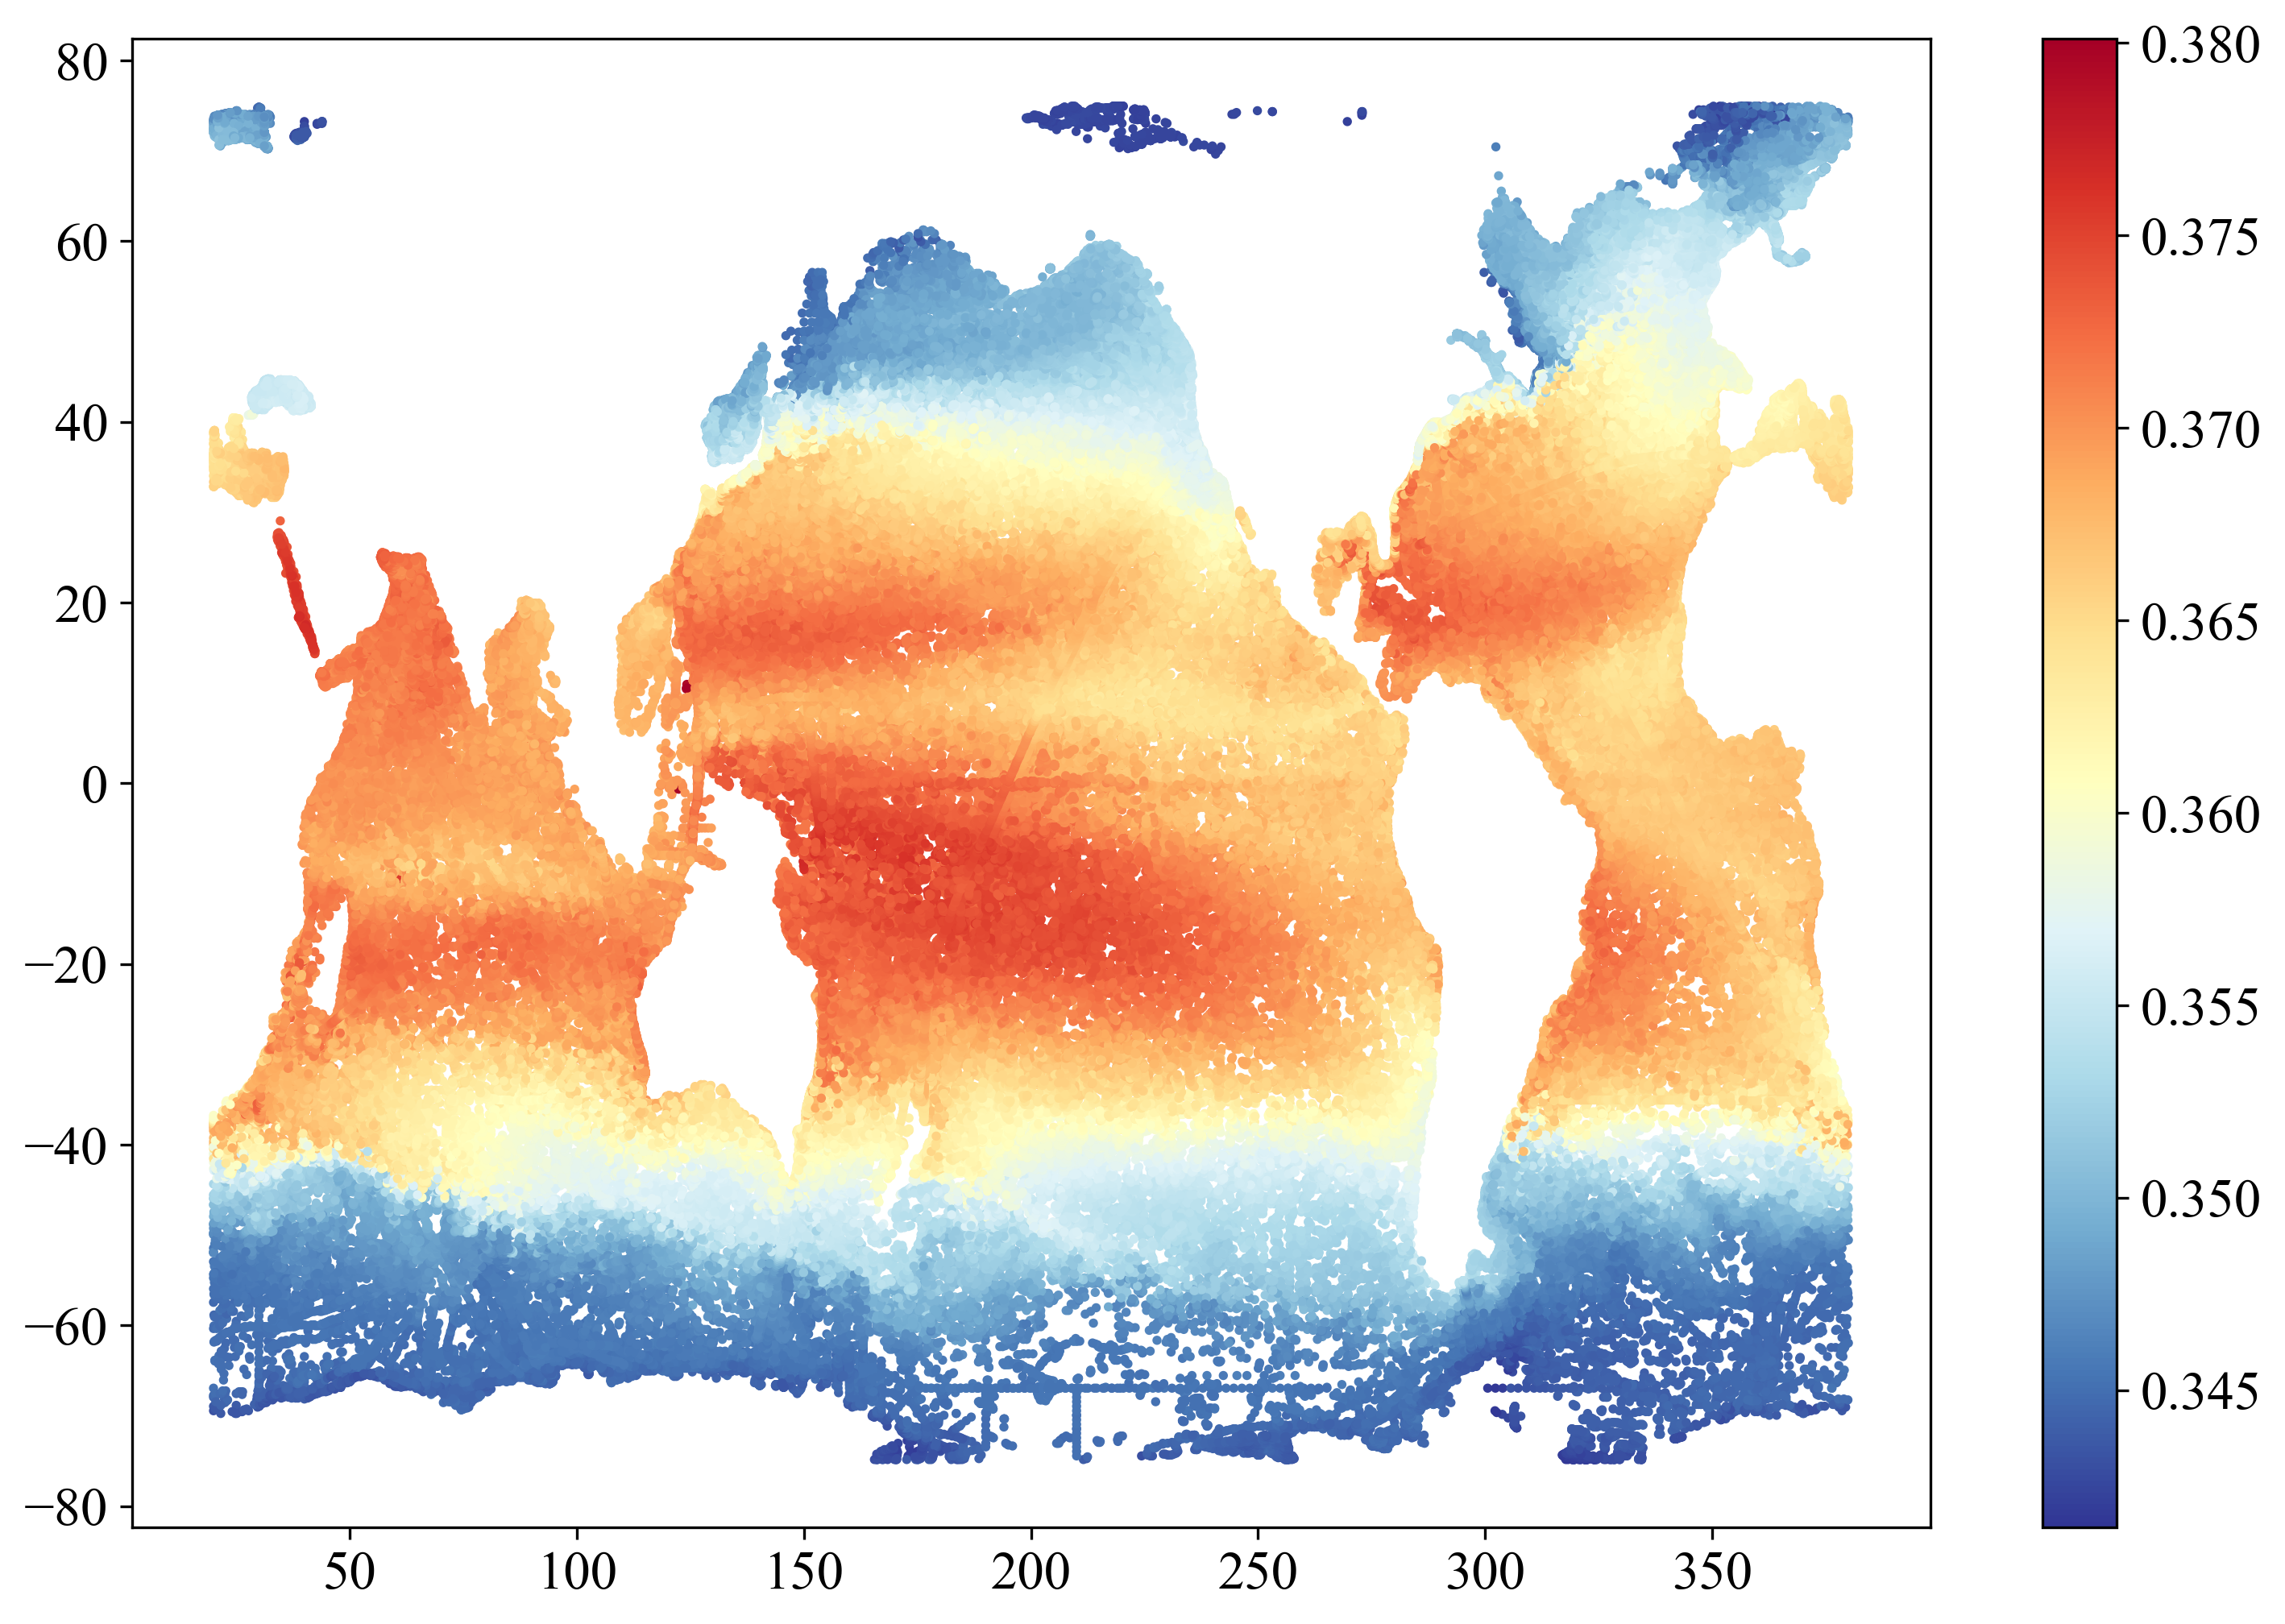

PyObject <matplotlib.colorbar.Colorbar object at 0x785c423ca3e0>

In [214]:
scat = plt.scatter(lon3[sel], lat3[sel], s=3, c=dohc3[sel], cmap=plt.cm.RdYlBu_r)
plt.colorbar(scat)

In [195]:
length(lon3), length(lat3), length(dates3), length(depth3), size(dohc3[:])

(13004810, 13004810, 13004810, 13004810, (13004810,))

### Prepare the time grid 
According to the time period specified in `config.jl`.

In [178]:
yearlistclim = [timeperiod1]
monthlist = 1:2
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlistclim, monthlist)
TSproduct = DIVAnd.TimeSelectorYearListMonthList(timeperiod1, monthlist)
length(TSbackground), length(TSproduct)

(2, 72)

In [179]:
sz = (length(longrid), length(latgrid), length(depthgrid))
lenx = fill(1000_000., sz)
leny = fill(1000_000., sz)
lenz = fill(0., sz);
len = (lenx, leny, lenz);
epsilon2 = 10.

10.0

## Create the climatology

In [208]:
size(mask_dohc)

(360, 180, 3)

In [215]:
mm = 3
gooddepth = findall(depth3 .== depthgrid[1])
goodtimes = findall(Dates.month.(dates3) .== mm)
sel = intersect(gooddepth, goodtimes);
@time fi, s = DIVAndrun(mask_dohc[:,:,1], (pm, pn), (xi, yi), (Float64.(lon3[sel]), Float64.(lat3[sel])), 
            Float64.(dohc3[sel]), (15., 15.), epsilon2, moddim=[1,0]);

  1.581890 seconds (2.42 M allocations: 949.139 MiB, 74.54% gc time)


In [224]:
dataresidual = DIVAnd_residual(s,fi);
typeof(dataresidual)

Vector{Float64} (alias for Array{Float64, 1})

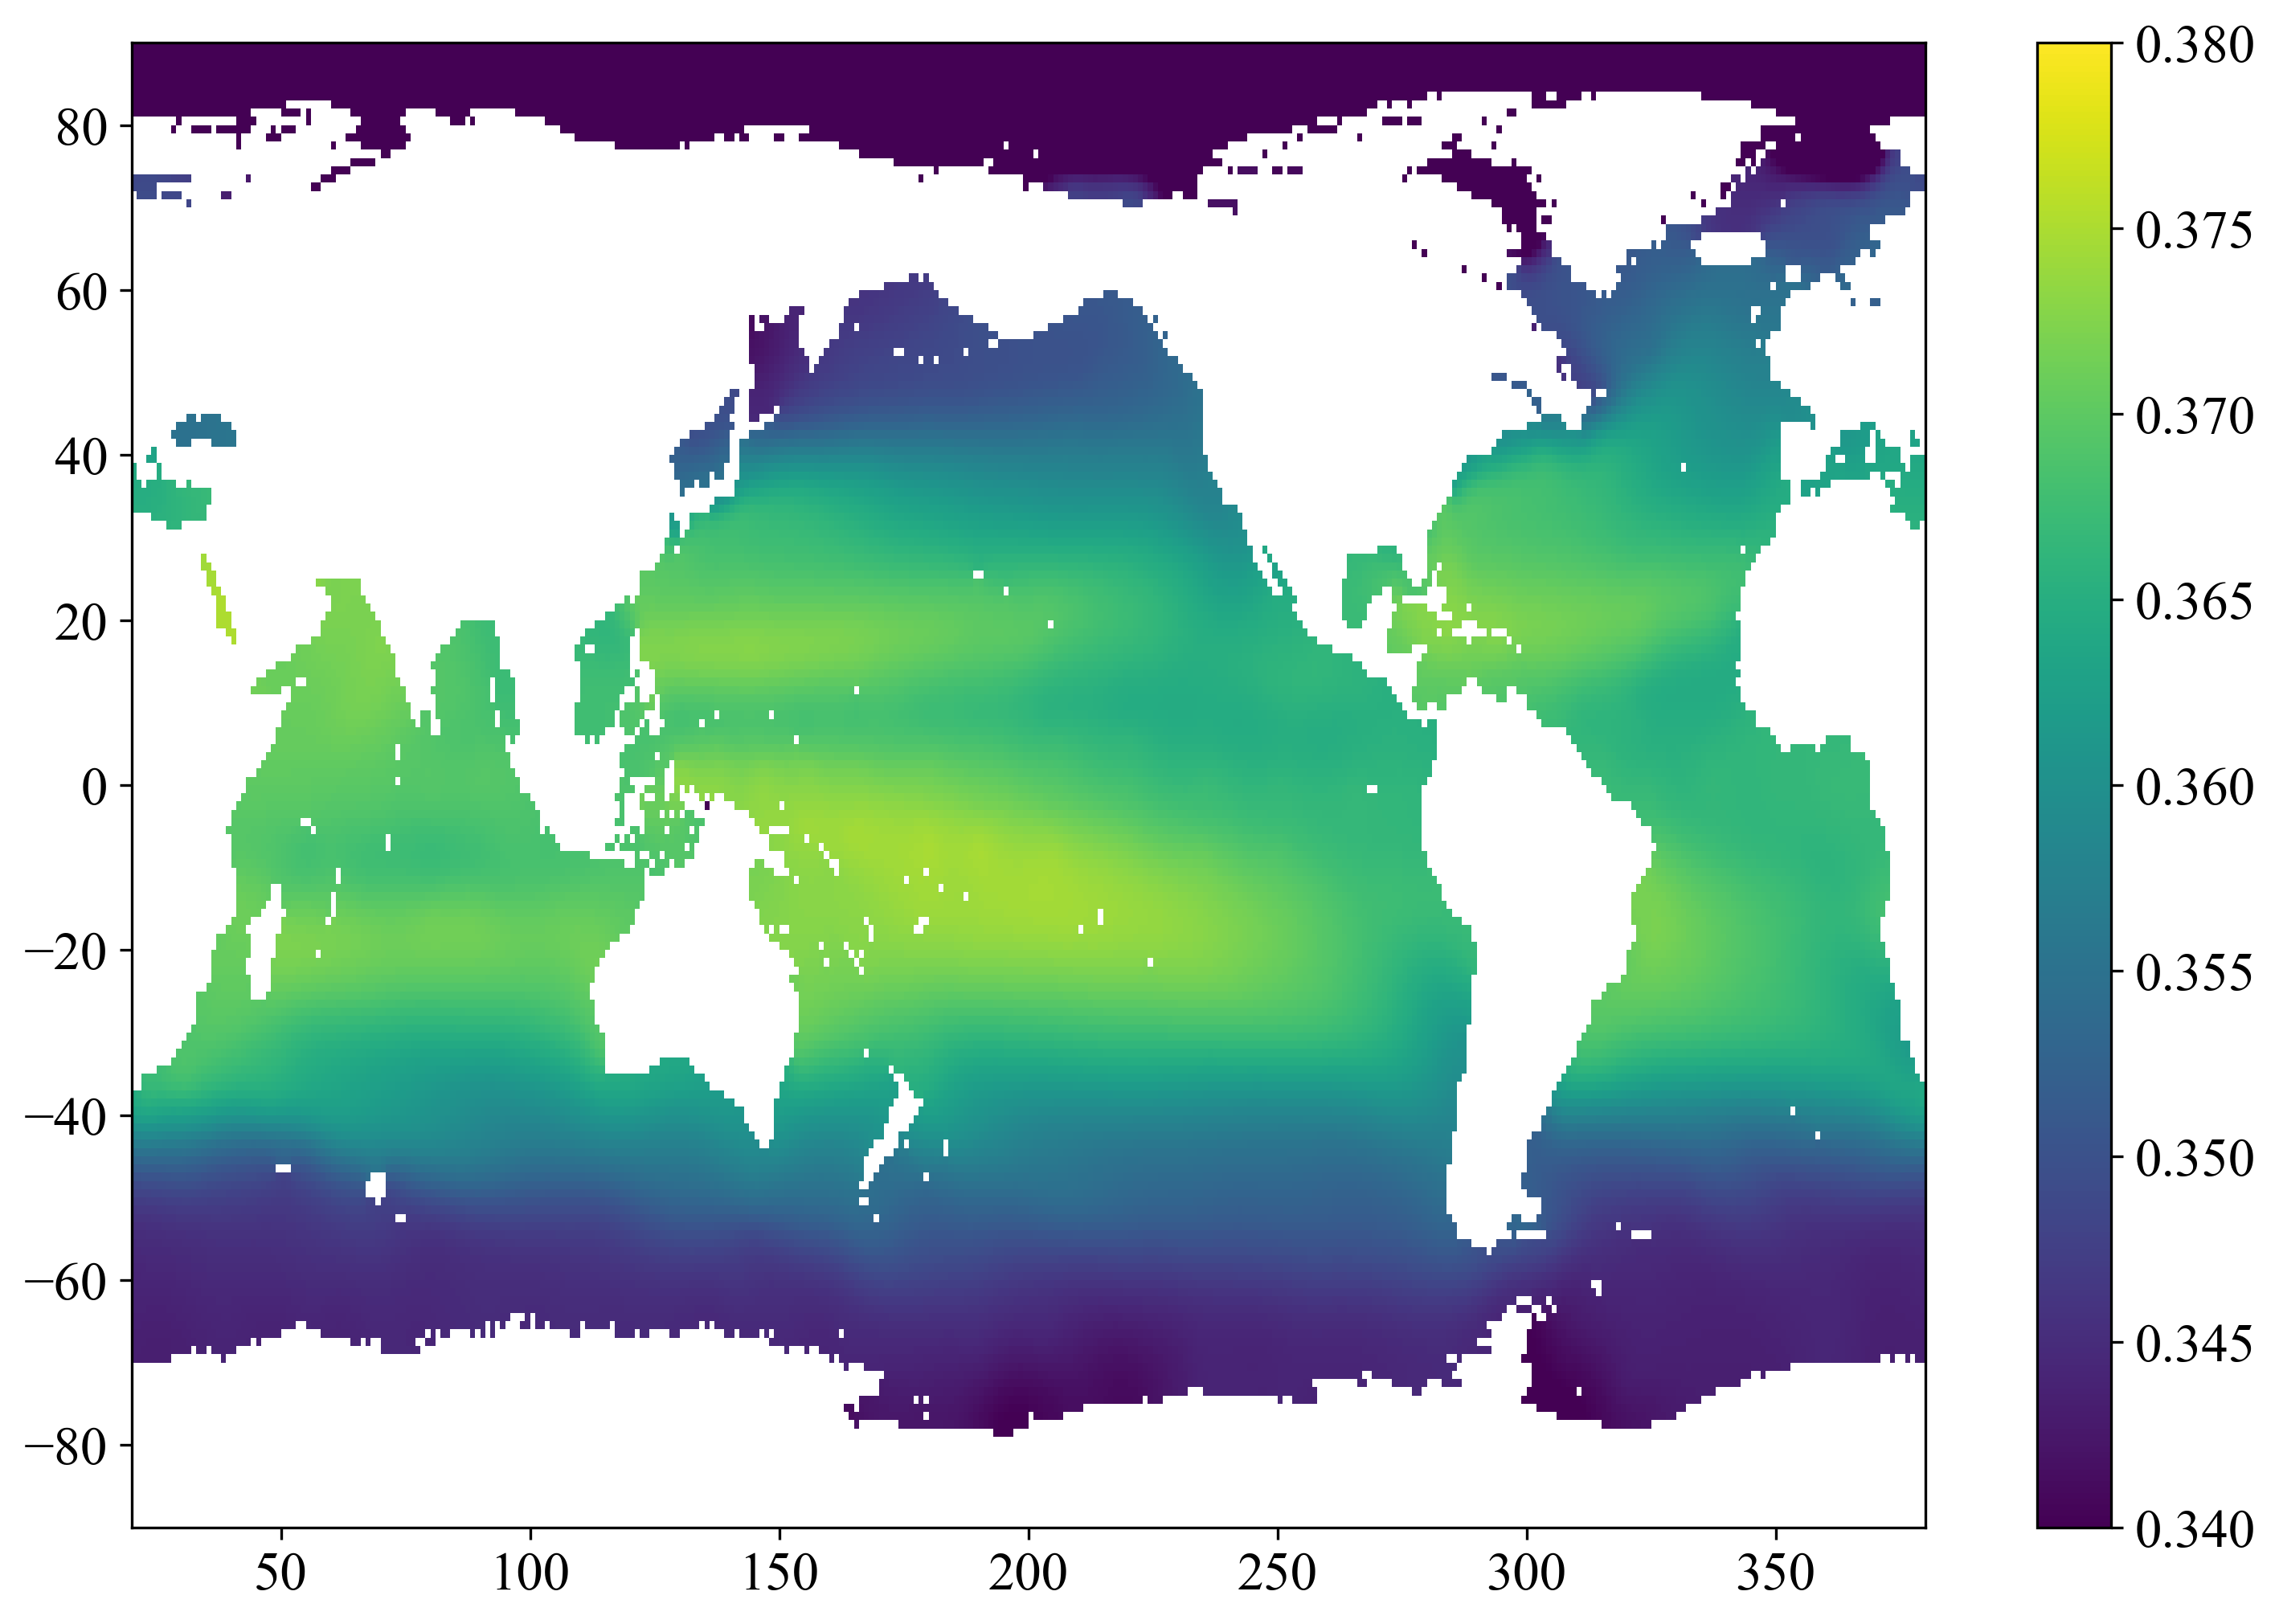

PyObject <matplotlib.colorbar.Colorbar object at 0x785c3d52f280>

In [216]:
pcm = plt.pcolormesh(longrid, latgrid, fi', vmin=0.34, vmax=0.38)
plt.colorbar(pcm)

In [180]:
    outputfile = joinpath(mainoutputdir, "test_diva3D.nc")
isfile(outputfile) ? rm(outputfile) : @debug("ok")
@time dbinfo = diva3d((longrid, latgrid, depthgrid, TSbackground),
    (lon3, lat3, depth3, dates3), dohc3,
    len, 1.,
    outputfile, "dohc",
    bathname=gebco16file,
    fitcorrlen = false,
    moddim=[0,1,0],
    timeorigin=DateTime(1900,1,1,0,0,0)
    );

[ Info: Creating netCDF file ../output/test_diva3D.nc
[ Info: Time step 1 / 2
[ Info: scaled correlation length (min,max) in dimension 1: (1.0e6, 1.0e6)
[ Info: scaled correlation length (min,max) in dimension 2: (1.0e6, 1.0e6)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
[ Info: number of windows: 1
[ Info: Time step 2 / 2
┌ Warning: no data at 2
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/diva.jl:441


  4.581386 seconds (1.34 M allocations: 7.439 GiB, 21.22% gc time, 15.31% compilation time)


## Create product

In [109]:
backgroundfun = DIVAnd.backgroundfile(outputfile, "dohc", TSbackground)

#621 (generic function with 1 method)

In [110]:
outputfile2 = joinpath(mainoutputdir, "test_diva3D_prod.nc")
isfile(outputfile2) ? rm(outputfile2) : @debug("ok")
@time dbinfo = diva3d((longrid, latgrid, depthgrid, TSproduct),
    (lon3, lat3, depth3, dates3), dohc3[:],
    len, epsilon2,
    outputfile2, "dohc",
    bathname=gebco16file,
    background=backgroundfun,
    fitcorrlen = false,
    moddim=[0,1,0]
    );

[ Info: Creating netCDF file ../output/test_diva3D_prod.nc
[ Info: Time step 1 / 432
[ Info: analysis time index 1 uses the background time index 1
[ Info: scaled correlation length (min,max) in dimension 1: (1.0e6, 1.0e6)
[ Info: scaled correlation length (min,max) in dimension 2: (1.0e6, 1.0e6)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
[ Info: number of windows: 1
[ Info: Time step 2 / 432
[ Info: analysis time index 2 uses the background time index 2
[ Info: scaled correlation length (min,max) in dimension 1: (1.0e6, 1.0e6)
[ Info: scaled correlation length (min,max) in dimension 2: (1.0e6, 1.0e6)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
[ Info: number of windows: 1
[ Info: Time step 3 / 432
[ Info: analysis time index 3 uses the background time index 3
[ Info: scaled correlation length (min,max) in dimension 1: (1.0e6, 1.0e6)
[ Info: scaled correlation length (min,max) in dimension 2: (1.0e6, 1.0e6)
[ Info: scaled correlati

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @[39m [90m./[39m[90m[4mboot.jl:477[24m[39m[90m [inlined][39m
      [2] [0m[1msparse[22m[0m[1m([22m[90mI[39m::[0mVector[90m{Int64}[39m, [90mJ[39m::[0mVector[90m{Int64}[39m, [90mV[39m::[0mVector[90m{Float64}[39m, [90mm[39m::[0mInt64, [90mn[39m::[0mInt64, [90mcombine[39m::[0mFunction[0m[1m)[22m
    [90m    @[39m [32mSparseArrays[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/SparseArrays/src/[39m[90m[4msparsematrix.jl:1076[24m[39m
      [3] [0m[1msparse[22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/SparseArrays/src/[39m[90m[4msparsematrix.jl:1318[24m[39m[90m [inlined][39m
      [4] [0m[1m_sparse_wsum[22m[0m[1m([22m[90msz1[39m::[0mTuple[90m{Int64, Int64, Int64}[39m, [90mm[39m::[0mInt64, [90mv1[39m::[0mFloat64, [90mv2[39m::[0mFloat64, [90mcyclic[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [36mDIVAnd[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4msparse_diff.jl:34[24m[39m
      [5] [0m[1msparse_stagger[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4msparse_stagger.jl:9[24m[39m[90m [inlined][39m
      [6] [0m[1moper_stagger[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mfunction_operator.jl:14[24m[39m[90m [inlined][39m
      [7] [0m[1mDIVAnd_laplacian[22m[0m[1m([22m[90moperatortype[39m::[0mType, [90mmask[39m::[0mBitArray[90m{3}[39m, [90mpmn[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mnu[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90miscyclic[39m::[0mBitVector; [90mcoeff_laplacian[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [36mDIVAnd[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAnd_laplacian.jl:69[24m[39m
      [8] [0m[1mDIVAnd_laplacian[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAnd_laplacian.jl:49[24m[39m[90m [inlined][39m
      [9] [0m[1mDIVAnd_operators[22m[0m[1m([22m[90moperatortype[39m::[0mType, [90mmask[39m::[0mBitArray[90m{3}[39m, [90mpmn[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mnu[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90miscyclic[39m::[0mBitVector, [90mmapindex[39m::[0mVector[90m{Any}[39m, [90mLabs[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m; [90mcoeff_laplacian[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [36mDIVAnd[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAnd_operators.jl:59[24m[39m
     [10] [0m[1mDIVAnd_background[22m[0m[1m([22m[90moperatortype[39m::[0mType, [90mmask[39m::[0mBitArray[90m{3}[39m, [90mpmn[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mLabs[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90malpha[39m::[0mVector[90m{Any}[39m, [90mmoddim[39m::[0mVector[90m{Int64}[39m, [90mscale_len[39m::[0mBool, [90mmapindex[39m::[0mVector[90m{Any}[39m; [90mbtrunc[39m::[0mInt64, [90mcoeff_laplacian[39m::[0mVector[90m{Float64}[39m, [90mcoeff_derivative2[39m::[0mVector[90m{Float64}[39m, [90mmean_Labs[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [36mDIVAnd[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAnd_background.jl:94[24m[39m
     [11] [0m[1mDIVAnd_background[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAnd_background.jl:20[24m[39m[90m [inlined][39m
     [12] [0m[1mDIVAndrun[22m[0m[1m([22m[90moperatortype[39m::[0mType, [90mmask[39m::[0mBitArray[90m{3}[39m, [90mpmnin[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mxiin[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mx[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Vector{Float64}}[39m, [90mf[39m::[0mVector[90m{Float64}[39m, [90mlin[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mepsilon2[39m::[0mVector[90m{Float64}[39m; [90mvelocity[39m::[0mTuple[90m{}[39m, [90mprimal[39m::[0mBool, [90mfactorize[39m::[0mBool, [90mtol[39m::[0mFloat64, [90mmaxit[39m::[0mInt64, [90mminit[39m::[0mInt64, [90mconstraints[39m::[0mTuple[90m{}[39m, [90mineqconstraints[39m::[0mTuple[90m{}[39m, [90mntriesmax[39m::[0mInt64, [90minversion[39m::[0mSymbol, [90mmoddim[39m::[0mVector[90m{Int64}[39m, [90mfracindex[39m::[0mMatrix[90m{Float64}[39m, [90malpha[39m::[0mVector[90m{Any}[39m, [90mkeepLanczosVectors[39m::[0mInt64, [90mcompPC[39m::[0mDIVAnd.var"#compPCa#239", [90mprogress[39m::[0mDIVAnd.var"#289#293", [90mfi0[39m::[0mArray[90m{Float64, 3}[39m, [90mf0[39m::[0mVector[90m{Float64}[39m, [90malphabc[39m::[0mFloat64, [90mscale_len[39m::[0mBool, [90mbtrunc[39m::[0mInt64, [90mMEMTOFIT[39m::[0mInt64, [90mtopographyforfluxes[39m::[0mTuple[90m{}[39m, [90mfluxes[39m::[0mTuple[90m{}[39m, [90mepsfluxes[39m::[0mInt64, [90mepsilon2forfractions[39m::[0mInt64, [90mRTIMESONESCALES[39m::[0mTuple[90m{}[39m, [90mQCMETHOD[39m::[0mTuple[90m{}[39m, [90mcoeff_laplacian[39m::[0mVector[90m{Float64}[39m, [90mcoeff_derivative2[39m::[0mVector[90m{Float64}[39m, [90mmean_Labs[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [36mDIVAnd[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAndrun.jl:154[24m[39m
     [13] [0m[1m#DIVAndrun#295[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAndrun.jl:401[24m[39m[90m [inlined][39m
     [14] [0m[1mDIVAndrun[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAndrun.jl:389[24m[39m[90m [inlined][39m
     [15] [0m[1mDIVAndjog[22m[0m[1m([22m[90mmask[39m::[0mBitArray[90m{3}[39m, [90mpmn[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mxi[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mx[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Vector{Float64}}[39m, [90mf[39m::[0mVector[90m{Float64}[39m, [90mLabs[39m::[0mTuple[90m{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}[39m, [90mepsilon2[39m::[0mVector[90m{Float64}[39m, [90mcsteps[39m::[0mVector[90m{Int64}[39m, [90mlmask[39m::[0mVector[90m{Float64}[39m, [90mpcmethod[39m::[0mInt64; [90mrng[39m::[0mRandom._GLOBAL_RNG, [90malphapc[39m::[0mVector[90m{Int64}[39m, [90motherargs[39m::[0m@Kwargs[90m{moddim::Vector{Int64}, MEMTOFIT::Int64, QCMETHOD::Tuple{}, RTIMESONESCALES::Tuple{}, velocity::Tuple{}, mean_Labs::Vector{Float64}}[39m[0m[1m)[22m
    [90m    @[39m [36mDIVAnd[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAndjog.jl:150[24m[39m
     [16] [0m[1mDIVAndjog[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAndjog.jl:26[24m[39m[90m [inlined][39m
     [17] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/.julia/packages/DIVAnd/BQFGA/src/[39m[90m[4mDIVAndgo.jl:187[24m[39m[90m [inlined][39m
     [18] [0m[1m(::DIVAnd.var"#297#306"{3, Vector{Int64}, Int64, Tuple{}, Tuple{}, @Kwargs{}, BitArray{3}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}, Vector{Float64}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Vector{Float64}, Symbol, Vector{Float64}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedArray{Float32, 3}, SharedArrays.SharedArray{Float32, 3}, Vector{Int64}, Vector{Float64}, Vector{Int64}, Vector{NTuple{6, Vector{Int64}}}, Bool, Bool})[22m[0m[1m([22m[90mR[39m::[0mUnitRange[90m{Int64}[39m, [90mlo[39m::[0mInt64, [90mhi[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [36mDIVAnd[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mmacros.jl:303[24m[39m
     [19] [0m[1m(::Distributed.var"#178#180"{UnitRange{Int64}, DIVAnd.var"#297#306"{3, Vector{Int64}, Int64, Tuple{}, Tuple{}, @Kwargs{}, BitArray{3}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}, Vector{Float64}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Vector{Float64}, Symbol, Vector{Float64}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedArray{Float32, 3}, SharedArrays.SharedArray{Float32, 3}, Vector{Int64}, Vector{Float64}, Vector{Int64}, Vector{NTuple{6, Vector{Int64}}}, Bool, Bool}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [33mDistributed[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mmacros.jl:83[24m[39m
     [20] [0m[1m#invokelatest#2[22m
    [90m    @[39m [90m./[39m[90m[4messentials.jl:892[24m[39m[90m [inlined][39m
     [21] [0m[1minvokelatest[22m
    [90m    @[39m [90m./[39m[90m[4messentials.jl:889[24m[39m[90m [inlined][39m
     [22] [0m[1m#153[22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mremotecall.jl:425[24m[39m[90m [inlined][39m
     [23] [0m[1mrun_work_thunk[22m[0m[1m([22m[90mthunk[39m::[0mDistributed.var"#153#154"[90m{Distributed.var"#178#180"{UnitRange{Int64}, DIVAnd.var"#297#306"{3, Vector{Int64}, Int64, Tuple{}, Tuple{}, @Kwargs{}, BitArray{3}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}, Vector{Float64}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Vector{Float64}, Symbol, Vector{Float64}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedArray{Float32, 3}, SharedArrays.SharedArray{Float32, 3}, Vector{Int64}, Vector{Float64}, Vector{Int64}, Vector{NTuple{6, Vector{Int64}}}, Bool, Bool}, UnitRange{Int64}}, Tuple{}, @Kwargs{}}[39m, [90mprint_error[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [33mDistributed[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:70[24m[39m
     [24] [0m[1mrun_work_thunk[22m[0m[1m([22m[90mrv[39m::[0mDistributed.RemoteValue, [90mthunk[39m::[0mFunction[0m[1m)[22m
    [90m    @[39m [33mDistributed[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:79[24m[39m
     [25] [0m[1m(::Distributed.var"#100#102"{Distributed.RemoteValue, Distributed.var"#153#154"{Distributed.var"#178#180"{UnitRange{Int64}, DIVAnd.var"#297#306"{3, Vector{Int64}, Int64, Tuple{}, Tuple{}, @Kwargs{}, BitArray{3}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}, Vector{Float64}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Vector{Float64}, Symbol, Vector{Float64}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedArray{Float32, 3}, SharedArrays.SharedArray{Float32, 3}, Vector{Int64}, Vector{Float64}, Vector{Int64}, Vector{NTuple{6, Vector{Int64}}}, Bool, Bool}, UnitRange{Int64}}, Tuple{}, @Kwargs{}}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [33mDistributed[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:88[24m[39m
    Stacktrace:
     [1] [0m[1msync_end[22m[0m[1m([22m[90mc[39m::[0mChannel[90m{Any}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mtask.jl:448[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mtask.jl:480[24m[39m[90m [inlined][39m
     [3] [0m[1m(::Distributed.var"#177#179"{DIVAnd.var"#297#306"{3, Vector{Int64}, Int64, Tuple{}, Tuple{}, @Kwargs{}, BitArray{3}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}, Vector{Float64}, Tuple{Array{Float64, 3}, Array{Float64, 3}, Array{Float64, 3}}, Vector{Float64}, Symbol, Vector{Float64}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedVector{Float32}, SharedArrays.SharedArray{Float32, 3}, SharedArrays.SharedArray{Float32, 3}, Vector{Int64}, Vector{Float64}, Vector{Int64}, Vector{NTuple{6, Vector{Int64}}}, Bool, Bool}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [33mDistributed[39m [90m~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mmacros.jl:278[24m[39m

In [191]:
# Create mask for the considered depth level
_, (pm, pn), (xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid)
_, _, mask = DIVAnd.load_mask(gebco16file, true, longrid, latgrid, depthlayer1[2])

@time fi, s = DIVAndrun(mask, (pm, pn), (xi, yi), (Float64.(lon3[sel2]), Float64.(lat3[sel2])), 
Float64.(dohc3[sel2]), 15., epsilon2, moddim=[1,0]);

┌ Warning: Observations equal to NaN: 54349
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/DIVAnd_obs.jl:45


  0.863364 seconds (2.40 M allocations: 925.267 MiB, 57.79% gc time)


In [100]:
pcm = plt.pcolormesh(longrid, latgrid, fi', cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcm)

LoadError: UndefVarError: `fi` not defined

## Perform analysis
### Create the netCDF files that will store the results
The output directory is specified in `config.jl`.

In [7]:
outputfilelist = []
for depthlayer in [depthlayer1, depthlayer2, depthlayer3]
    fname = make_fname(timeperiod1, depthlayer, "A")
    outputfile = joinpath(outputdir, fname)
    isfile(outputfile) ? rm(outputfile) : @debug("OK")
    create_netcdf_results(outputfile, longrid, latgrid, timegrid1)
    
    # Add the residual variables in the netCDF
    add_residuals(outputfile, datafilelist)
    
    # Add file to the list
    push!(outputfilelist, outputfile)
end

LoadError: UndefVarError: `make_fname` not defined

### Loop on the files and the depths

In [8]:
for (ntime, datafile) in enumerate(datafilelist)
    
    # Read observations
    lon, lat, dates, depth, T, S, dohc = read_profile(datafile)
    
    # Modify coordinates
    lon[lon .< 20.] .+= 360
    
    # Loop on the 3 depth levels
    for ii = 1:1
        
        # Select good values (no NaNs)
        obsval = dohc[ii,:]
        goodval = findall(.!isnan.(obsval));
        ngood = length(goodval)
        
        # Perform interpolation
        fi, s = DIVAndrun(mask_dohc[:,:,ii], (pm, pn), (xi, yi), (Float64.(lon[goodval]), 
        Float64.(lat[goodval])), Float64.(obsval[goodval] .- mean(obsval[goodval])), 
        (5., 5.), 10.; moddim=[1,0])
        
        # Compute residuals
        dataresidual = DIVAnd_residual(s, fi)
        
        # Write field and residual in the netCDF
        NCDataset(outputfilelist[ii], "a") do ds
            ds["dohc"][:,:,ntime] = fi
            ds["obslon"][1:ngood,ntime] = lon[goodval]
            ds["obslat"][1:ngood,ntime] = lat[goodval]
            ds["obstime"][1:ngood,ntime] = dates[goodval]
            ds["dohc_residuals"][1:ngood,ntime] = dataresidual
        end
        
        # Make plot
        if doplot
            fig = plt.figure(figsize=(15, 8))
            ax = plt.subplot(121)
            ax.scatter(lon[goodval], lat[goodval], s=3, c=obsval[goodval])
            ax.set_xlim(20., 380.)
            ax = plt.subplot(122)
            ax.pcolormesh(longrid, latgrid, fi' .+ mean(obsval[goodval]))
            ax.set_xlim(20., 380.)
            plt.show()
        end
    end
end

LoadError: UndefVarError: `read_profile` not defined

## Temperature analysis

In [9]:
datafile = datafilelist[1]

"/home/ctroupin/data/ME4OH/data/en4.1.1/1979-2014/full/update/ofam3-jra55.all.EN.4.1.1.f.profiles.g10.197901.update.nc"

In [10]:
lon, lat, dates, depth, T, S, dohc = ME4OH.read_profile(datafile)
lon[lon .< 20.] .+= 360;
obslon, obslat, obsdates, obsdepth, T, S = ME4OH.vectorize_obs(lon, lat, dates, depth, T, S);

In [11]:
length(obslat)

354170

### Set grids
Lon and lat grid are defined in `config.jl`.     
The depth levels are the same as the profiles.

In [12]:
depthgrid = depth;

### Set the analysis parameters

In [13]:
sz = (length(longrid), length(latgrid), length(depthgrid))

lenx = fill(20.,sz)
leny = fill(20.,sz)
lenz = fill(0., sz);
len = (lenx, leny, lenz);
epsilon2 = 5.

5.0

### Run the analysis

In [14]:
_, pmn, xyi = DIVAnd_rectdom(longrid, latgrid, depthgrid);

In [15]:
xi, yi, mask = load_mask(bathyfile, true, longrid, latgrid, depthgrid);

In [16]:
@time Tinterp, s = DIVAndrun(mask, pmn, xyi, (obslon, obslat, obsdepth), Float64.(T .- mean(T)),
len, epsilon2, moddim=[1,0,0]);

LoadError: InterruptException:

In [18]:
dindex = 25
xi, yi, mask2D = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, depthgrid[dindex]);        
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
depthsel = findall(obsdepth .== depthgrid[dindex])
@time Tinterp2, s2 = DIVAndrun(mask2D, (pm, pn), (xi, yi), (obslon[depthsel], obslat[depthsel]), 
Float64.(T[depthsel] .- mean(T[depthsel])), 
(20., 20.), epsilon2, moddim=[1,0]);

vmin = quantile(T[depthsel], 0.02)
vmax = quantile(T[depthsel], 0.98)

fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(131)
pcm = plt.pcolormesh(longrid, latgrid, mean(T) .+ Tinterp[:,:,dindex]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.set_title("DIVA 3D Temperature at $(depthgrid[dindex]) m")

ax = plt.subplot(132)
pcm = ax.pcolormesh(longrid, latgrid, mean(T[depthsel]) .+ Tinterp2[:,:]', 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5)
plt.colorbar(pcm)
ax.set_xlim(20., 380.)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
ax.set_title("DIVA 2D Temperature at $(depthgrid[dindex]) m")


ax = plt.subplot(133)
ax.pcolormesh(longrid, latgrid, mask[:,:,dindex]', cmap=plt.cm.binary_r, zorder=3)
pcm = ax.scatter(obslon[depthsel], obslat[depthsel], s=5, c=T[depthsel], 
cmap=plt.cm.RdYlBu_r, vmin=vmin, vmax=vmax, zorder=5);
ax.set_xlim(20., 380.)
plt.colorbar(pcm)
ax.set_title("Temperature measurements at $(depthgrid[dindex]) m")
plt.savefig(joinpath(figdir, "comparison_3D_2D_level-$(dindex).jpg"), dpi=300, bbox_inches="tight")

  8.498105 seconds (6.19 M allocations: 938.385 MiB, 7.37% gc time, 91.70% compilation time)


LoadError: UndefVarError: `Tinterp` not defined